In [1205]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import category_encoders as ce
from datetime import datetime
from scipy.stats import chi2_contingency
from scipy.stats import chi2

In [1206]:
df = pd.read_csv('ds_challenge_v2_1_data.csv')

In [1207]:
df.dtypes

id                        int64
city_name                object
signup_os                object
signup_channel           object
signup_date              object
bgc_date                 object
vehicle_added_date       object
vehicle_make             object
vehicle_model            object
vehicle_year            float64
first_completed_date     object
dtype: object

In [1208]:
df.head()

,id,city_name,signup_os,signup_channel,signup_date,bgc_date,vehicle_added_date,vehicle_make,vehicle_model,vehicle_year,first_completed_date
0,1,Strark,ios web,Paid,1/2/16,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Strark,windows,Paid,1/21/16,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Wrouver,windows,Organic,1/11/16,1/11/16,NaN,NaN,NaN,NaN,NaN
3,4,Berton,android web,Referral,1/29/16,2/3/16,2/3/16,Toyota,Corolla,2016.0,2/3/16
4,5,Strark,android web,Referral,1/10/16,1/25/16,1/26/16,Hyundai,Sonata,2016.0,NaN


<AxesSubplot:xlabel='null_count', ylabel='index'>

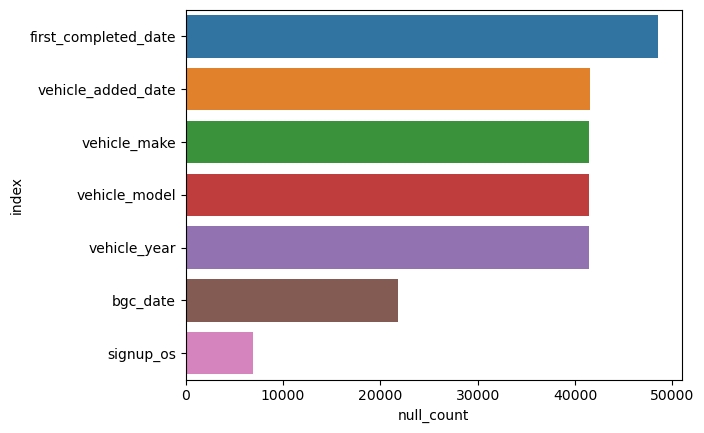

In [1122]:
# Here I notice that over 85% of first_completed_dates are nulls indicating that only 15% of drivers who signed up completed their first ride. This going to be our target metric.
# More than 75% of the rows about Vehicle added date, Vehicle Information are empty hence I will be ignoring them. 
nulls = df.isnull().sum()
nulls = nulls[nulls!=0]
nulls = nulls.reset_index(name = 'null_count')
nulls = nulls.sort_values('null_count', ascending=False)
sns.barplot(data=nulls, x='null_count', y='index')

In [1123]:
#Dropping the Vehicle information columns
df = df.drop('vehicle_added_date', axis = 1)
df = df.drop('vehicle_make', axis = 1)
df = df.drop('vehicle_model', axis = 1)
df = df.drop('vehicle_year', axis = 1)

In [1124]:
# ~10% of rows are NAs within SignupOS feature. We will be ignoring the rows to eliminate the nulls.
df = df[df['signup_os'].notnull()]

In [1125]:
#Data type conversions
date_format = "%m/%d/%Y"
df['first_completed_date'] = pd.to_datetime(df['first_completed_date'])
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['bgc_date'] = pd.to_datetime(df['bgc_date'])

In [1126]:
# I am interested to know how long a driver takes to provide Background Check consent from the time they signedup.
# I creating a new field that shows the time in days between the above two events
df['signup_to_bgc'] = df['bgc_date'] - df['signup_date']
df['signup_to_bgc'] = df['signup_to_bgc'].astype(str)
df['signup_to_bgc'] = df['signup_to_bgc'].str.replace(' days', '')



In [1127]:
# Here I am replacing all the rows with a ride completed date with a 1 incdicating a success and a Null with 0
df['first_ride'] = df['first_completed_date']
df['first_ride'].fillna(0, inplace=True)
df['first_ride'] = df['first_ride'].apply(lambda x:1 if x!=0 else 0)

In [1128]:
df['signup_to_bgc'] = df['signup_to_bgc'].replace('NaT', np.nan)
df['signup_to_bgc'] = df['signup_to_bgc'].astype('Int64')

In [1130]:
df.isnull().sum()

id                          0
city_name                   0
signup_os                   0
signup_channel              0
signup_date                 0
bgc_date                16956
first_completed_date    41835
signup_to_bgc           16956
first_ride                  0
dtype: int64

In [1131]:
# I noticed that over 16k drivers did not consent to a background check and have not completed their first ride as well.
# I am going to be considering the rows of drivers who consented for background check as it helps us analyze on an important metrics we calculated - signup_to_bgc
df = df[df['signup_to_bgc'].notnull()]
df = df.drop('first_completed_date', axis=1 )

In [1132]:
df.head()

,id,city_name,signup_os,signup_channel,signup_date,bgc_date,signup_to_bgc,first_ride
2,3,Wrouver,windows,Organic,2016-01-11,2016-01-11,0,0
3,4,Berton,android web,Referral,2016-01-29,2016-02-03,5,1
4,5,Strark,android web,Referral,2016-01-10,2016-01-25,15,0
5,6,Strark,android web,Referral,2016-01-18,2016-01-18,0,0
6,7,Strark,ios web,Paid,2016-01-14,2016-01-16,2,1


In [1133]:
#Completed cleaning up all the Null rows in the dataset
df.isnull().sum()

id                0
city_name         0
signup_os         0
signup_channel    0
signup_date       0
bgc_date          0
signup_to_bgc     0
first_ride        0
dtype: int64

In [1135]:
len(df)

30868

In [1136]:
#Filtered some columns to a new dataframe to plot the data and get an understanding of the data
stacked = df[['city_name','signup_os','signup_to_bgc','first_ride', 'signup_channel' ]]

In [1137]:
stacked.head()

,city_name,signup_os,signup_to_bgc,first_ride,signup_channel
2,Wrouver,windows,0,0,Organic
3,Berton,android web,5,1,Referral
4,Strark,android web,15,0,Referral
5,Strark,android web,0,0,Referral
6,Strark,ios web,2,1,Paid


In [1162]:
pie = df.groupby(['first_ride'])['id'].count().reset_index()
pie['label'] = ['First Ride - Not Completed', 'First Ride - Completed']

In [1163]:
pie.head(6)

,first_ride,id,label
0,0,24879,First Ride - Not Completed
1,1,5989,First Ride - Completed


([<matplotlib.patches.Wedge at 0x7fc9e866dfd0>,
 [Text(-0.9019083972721935, 0.629731087790577, 'First Ride - Not Completed'),
  Text(0.901908426752032, -0.6297310455691976, 'First Ride - Completed')],
 [Text(-0.49195003487574185, 0.34348968424940557, '80.6%'),
  Text(0.4919500509556537, -0.3434896612195623, '19.4%')])

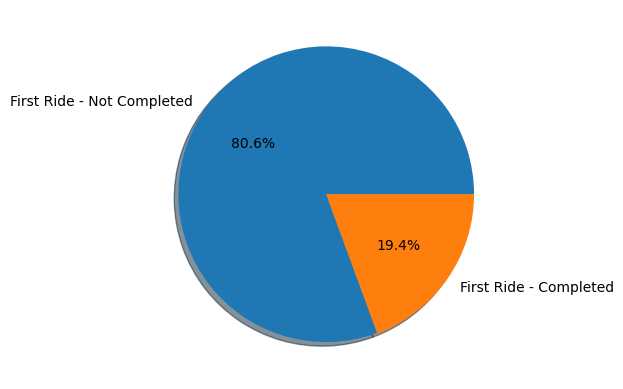

In [1167]:
# ~ 80% of drivers have not completed their first ride
plt.pie(x= pie.id, labels=pie.label, shadow = True, autopct='%.1f%%')

In [1179]:
pie2 = df.groupby(['city_name','first_ride'])['id'].count().reset_index()
pie3 = pie2[pie2['city_name'] =='Berton']
pie4 = pie2[pie2['city_name'] =='Strark']
pie5 = pie2[pie2['city_name'] =='Wrouver']
pie3['label'] = ['First Ride - Not Completed', 'First Ride - Completed']
pie4['label'] = ['First Ride - Not Completed', 'First Ride - Completed']
pie5['label'] = ['First Ride - Not Completed', 'First Ride - Completed']

/var/folders/cy/jqgb_3bd0t94k2zsfjl68hy00000gn/T/ipykernel_19478/4223216779.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pie3['label'] = ['First Ride - Not Completed', 'First Ride - Completed']
/var/folders/cy/jqgb_3bd0t94k2zsfjl68hy00000gn/T/ipykernel_19478/4223216779.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pie4['label'] = ['First Ride - Not Completed', 'First Ride - Completed']
/var/folders/cy/jqgb_3bd0t94k2zsfjl68hy00000gn/T/ipykernel_19478/4223216779.py:7: SettingWithCopyWarning: 
A v

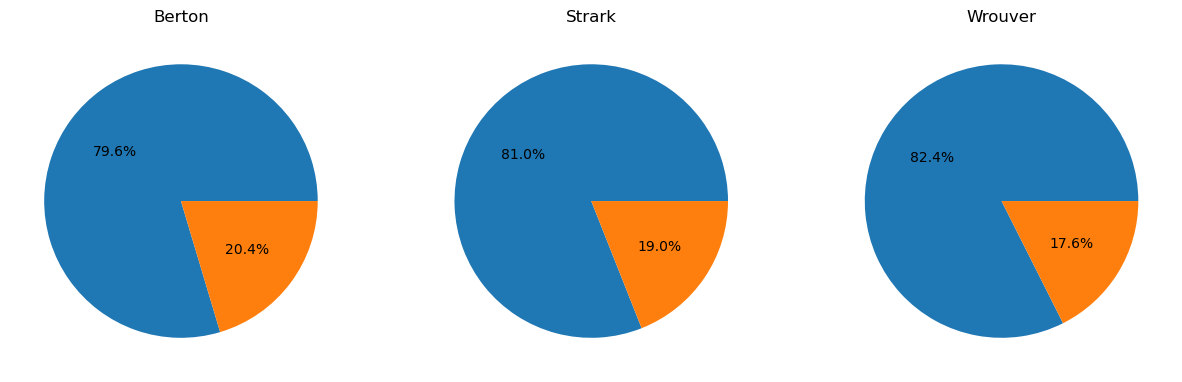

In [1204]:
# The 20% driver completion rate pretty much seems consistent across all cities
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 15))
ax1.pie(pie3.id, autopct='%.1f%%')
ax2.pie(pie4.id, autopct='%.1f%%')
ax3.pie(pie5.id, autopct='%.1f%%')
ax1.title.set_text('Berton')
ax2.title.set_text('Strark')
ax3.title.set_text('Wrouver')

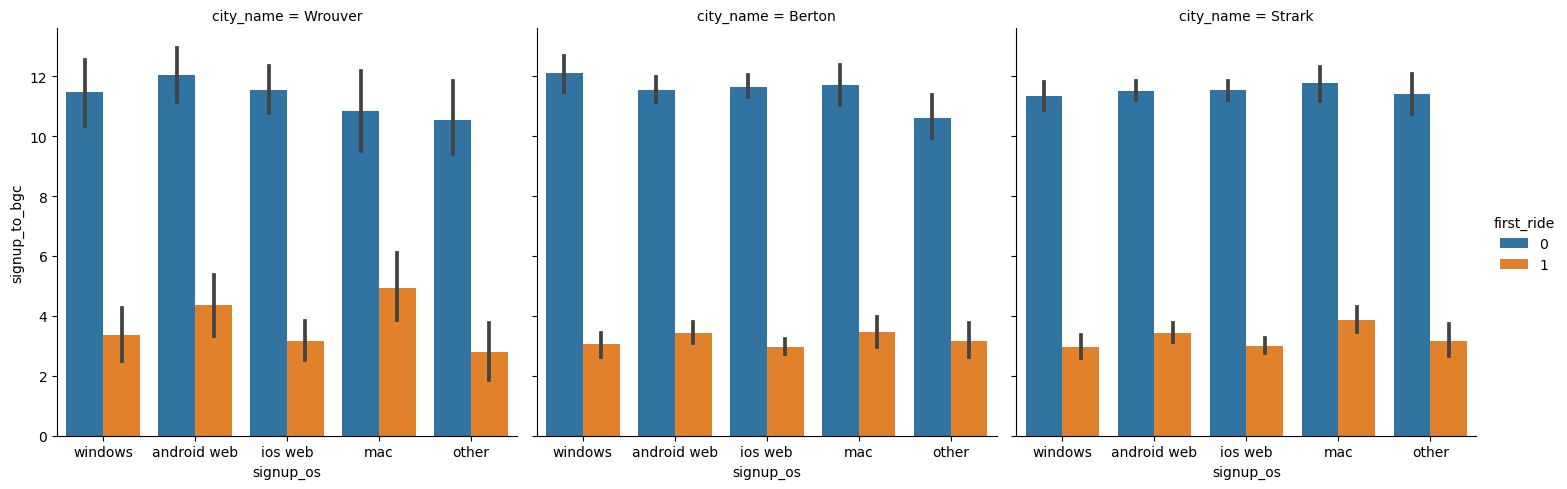

In [1239]:
# Drivers signed up through Mac are observed to have quickly submitted for background check across all 3 cities
sns.catplot(data = stacked,kind = 'bar', x='signup_os', y='signup_to_bgc', hue='first_ride', col = 'city_name')

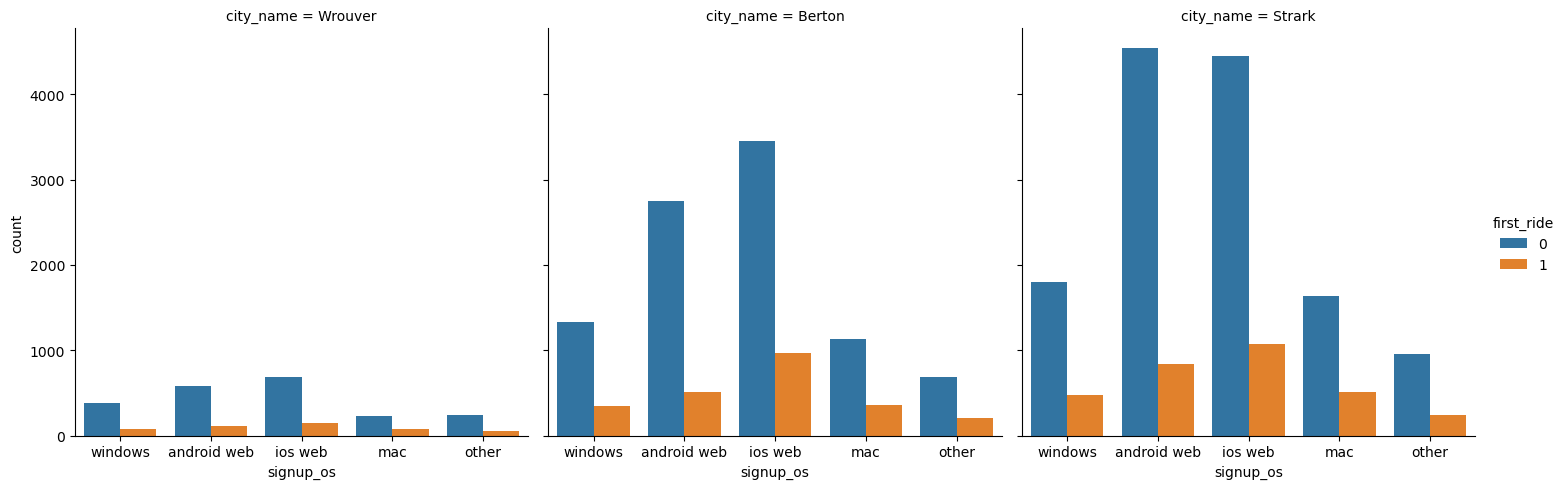

In [1241]:
# Drivers signed up through iOS are more likely to have completed their first ride/'' across all 3 cities
sns.catplot(data = stacked,kind = 'count', x='signup_os', hue='first_ride', col = 'city_name')

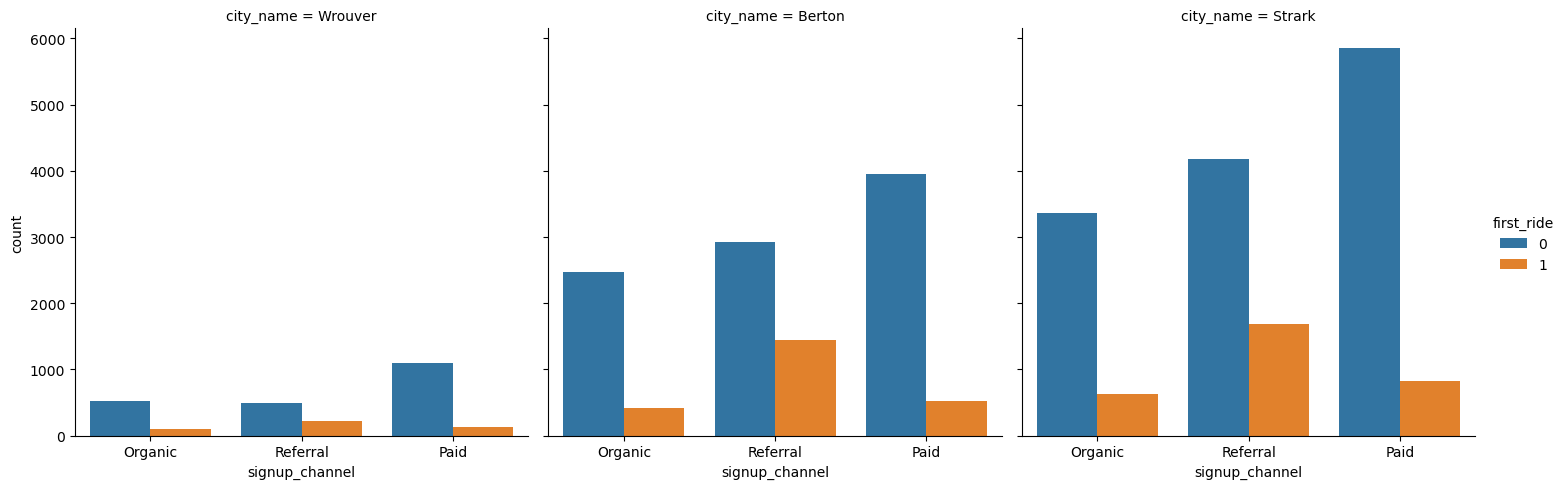

In [1043]:
#Drivers who sign up through referrals are more likely to take their first ride compared to Paid or Organic
# Very few driver signups are observed in Wrouver city as compared to the other two.
sns.catplot(data = stacked,kind = 'count', x='signup_channel', hue='first_ride', col = 'city_name')

In [1140]:
timeline = df[['signup_date', 'id', 'first_ride']]

In [1141]:
timeline = df.groupby(['signup_date', 'first_ride'])['id'].count().reset_index()

(array([16801., 16805., 16809., 16813., 16817., 16821., 16825., 16829.]),
 [Text(16801.0, 0, '2016-01-01'),
  Text(16805.0, 0, '2016-01-05'),
  Text(16809.0, 0, '2016-01-09'),
  Text(16813.0, 0, '2016-01-13'),
  Text(16817.0, 0, '2016-01-17'),
  Text(16821.0, 0, '2016-01-21'),
  Text(16825.0, 0, '2016-01-25'),
  Text(16829.0, 0, '2016-01-29')])

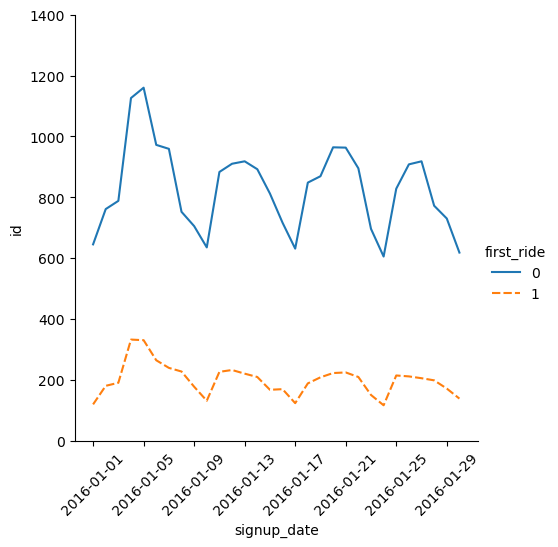

In [1142]:
# A high frequency of sign ups are observed in the first week of January
# The ratio of sign ups to first rides seem consistent over the entire month 
sns.relplot(data=timeline,x="signup_date", y="id",kind="line",hue ='first_ride', style="first_ride")
plt.ylim([0, 1400])
plt.xticks(rotation=45)

<AxesSubplot:xlabel='signup_to_bgc', ylabel='Count'>

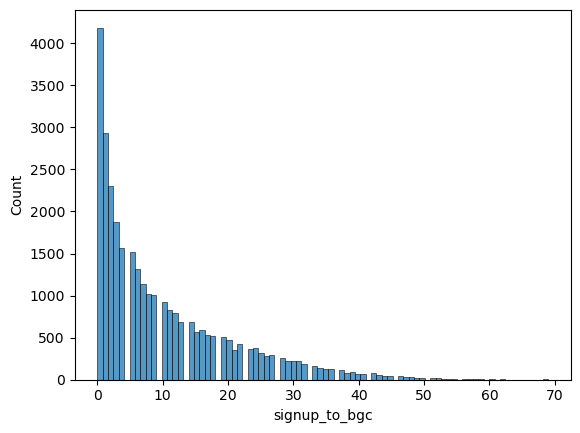

In [1047]:
# More than 60% of the drivers gave a background check consent in the first 10 days of signing up.
# ~10% of driver gave a background check consent more than 30 days later.
sns.histplot(data = stacked, x = 'signup_to_bgc')

In [1048]:
df.head()

,id,city_name,signup_os,signup_channel,signup_date,bgc_date,signup_to_bgc,first_ride
2,3,Wrouver,windows,Organic,2016-01-11,2016-01-11,0,0
3,4,Berton,android web,Referral,2016-01-29,2016-02-03,5,1
4,5,Strark,android web,Referral,2016-01-10,2016-01-25,15,0
5,6,Strark,android web,Referral,2016-01-18,2016-01-18,0,0
6,7,Strark,ios web,Paid,2016-01-14,2016-01-16,2,1


In [1049]:
#Dropping the additional columns to prepare for building a model
df = df.drop('signup_date', axis = 1)
df= df.drop('bgc_date', axis = 1)
df= df.drop('id', axis = 1)

In [1050]:
df.head()

,city_name,signup_os,signup_channel,signup_to_bgc,first_ride
2,Wrouver,windows,Organic,0,0
3,Berton,android web,Referral,5,1
4,Strark,android web,Referral,15,0
5,Strark,android web,Referral,0,0
6,Strark,ios web,Paid,2,1


**Chi-Square Test**

Performing this test to determine whether each of the features in the data set are dependant or indepandant of the output variable(ie. first_ride) 
I will be considering the features that are dependant of the output variable in the model. The independant features will be eliminated.

In [1051]:
chisq1 = df[['signup_to_bgc','first_ride']]
crosstab1 = pd.crosstab(chisq1['signup_to_bgc'], chisq1['first_ride'])
crosstab1

first_ride,0,1
signup_to_bgc,,
0,2370,1818
1,1854,1076
2,1619,690
3,1347,530
4,1219,343
...,...,...
58,1,0
59,1,0
60,1,0


In [1052]:
stat, p, dof, expected = chi2_contingency(crosstab1)
print('dof=%d' % dof)
print('p-Value: ',p)
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
 print('Dependent (reject H0).The two features are dependant with each other')
else:
 print('Independent (fail to reject H0). The two features are independant of each other')

dof=62
p-Value:  0.0
significance=0.050, p=0.000
Dependent (reject H0).The two features are dependant with each other


In [1053]:
chisq2 = df[['signup_channel','first_ride']]

In [1054]:
crosstab2 = pd.crosstab(chisq2['signup_channel'], chisq2['first_ride'])
crosstab2

first_ride,0,1
signup_channel,,
Organic,6366,1140
Paid,10910,1482
Referral,7603,3367


In [1055]:

stat, p, dof, expected = chi2_contingency(crosstab2)
print('dof=%d' % dof)
print('p-Value: ',p)
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
 print('Dependent (reject H0).The two features are dependant with each other')
else:
 print('Independent (fail to reject H0). The two features are independant of each other')

dof=2
p-Value:  9.419899587197045e-309
significance=0.050, p=0.000
Dependent (reject H0).The two features are dependant with each other


In [1056]:
chisq3 = df[['signup_os','first_ride']]
crosstab3 = pd.crosstab(chisq3['signup_os'],chisq3['first_ride'])
crosstab3

first_ride,0,1
signup_os,,
android web,7886,1454
ios web,8592,2191
mac,2997,948
other,1885,498
windows,3519,898


In [1057]:
stat, p, dof, expected = chi2_contingency(crosstab3)
print('dof=%d' % dof)
print('p-Value: ',p)
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
 print('Dependent (reject H0).The two features are dependant with each other')
else:
 print('Independent (fail to reject H0). The two features are independant of each other')

dof=4
p-Value:  3.6007844054690714e-32
significance=0.050, p=0.000
Dependent (reject H0).The two features are dependant with each other


In [1058]:
chisq4 = df[['city_name','first_ride']]
crosstab4 = pd.crosstab(chisq4['city_name'], chisq4['first_ride'])
crosstab4

first_ride,0,1
city_name,,
Berton,9355,2394
Strark,13400,3142
Wrouver,2124,453


In [1059]:
stat, p, dof, expected = chi2_contingency(crosstab4)
print('dof=%d' % dof)
print('p-Value: ',p)
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
 print('Dependent (reject H0).The two features are dependant with each other')
else:
 print('Independent (fail to reject H0). The two features are independant of each other')

dof=2
p-Value:  0.0007578258476752474
significance=0.050, p=0.001
Dependent (reject H0).The two features are dependant with each other


**Predictive Modeling**

In [1065]:
df.head()

,city_name,signup_os,signup_channel,signup_to_bgc,first_ride
2,Wrouver,windows,Organic,0,0
3,Berton,android web,Referral,5,1
4,Strark,android web,Referral,15,0
5,Strark,android web,Referral,0,0
6,Strark,ios web,Paid,2,1


In [1066]:
# Since the models will accept a numerical input I am encoding the city_name, signup_os and signup_channel features 
#and splitting them into their relevant columns.

encoder1=ce.OneHotEncoder(cols='city_name',handle_unknown='return_nan',return_df=True,use_cat_names=True)
encoder2=ce.OneHotEncoder(cols='signup_os',handle_unknown='return_nan',return_df=True,use_cat_names=True)
encoder3=ce.OneHotEncoder(cols='signup_channel',handle_unknown='return_nan',return_df=True,use_cat_names=True)
df = encoder1.fit_transform(df)
df = encoder2.fit_transform(df)
df = encoder3.fit_transform(df)


In [1067]:
df.head()

,city_name_Wrouver,city_name_Berton,city_name_Strark,signup_os_windows,signup_os_android web,signup_os_ios web,signup_os_mac,signup_os_other,signup_channel_Organic,signup_channel_Referral,signup_channel_Paid,signup_to_bgc,first_ride
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,5,1
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,15,0
5,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0
6,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2,1


In [1074]:
df.isnull().sum()

city_name_Wrouver          0
city_name_Berton           0
city_name_Strark           0
signup_os_windows          0
signup_os_android web      0
signup_os_ios web          0
signup_os_mac              0
signup_os_other            0
signup_channel_Organic     0
signup_channel_Referral    0
signup_channel_Paid        0
signup_to_bgc              0
first_ride                 0
dtype: int64

In [1068]:
X = df.drop('first_ride', axis = 1)
y = df[['first_ride']]

**Logistic Regression**

In [1078]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)


y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.82


/Users/rajesh/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [1079]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred) 

cnf_matrix 

array([[7865,  335],
       [1549,  438]])

In [1080]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred)) 

Accuracy: 0.8150584077746147


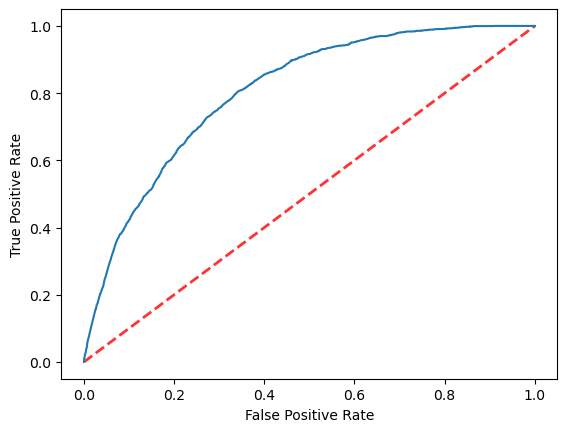

In [1098]:
#define metrics
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Random', alpha=.8)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [1099]:
auc = metrics.roc_auc_score(y_test, y_pred_proba)
print(auc)


0.804302570365915


**Random Forest Classifier**

In [1093]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=50, max_features="auto", random_state=44)
rf_model.fit(X_train, y_train)

/var/folders/cy/jqgb_3bd0t94k2zsfjl68hy00000gn/T/ipykernel_19478/1794165630.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


RandomForestClassifier(n_estimators=50, random_state=44)

In [1094]:
predictions = rf_model.predict(X_test)

In [1095]:
rf_model.feature_importances_

array([0.00912908, 0.00990005, 0.01104794, 0.00953392, 0.01952816,
       0.00858758, 0.0135416 , 0.00929069, 0.01510427, 0.12684224,
       0.04918843, 0.71830604])

In [1096]:
rf_model.score(X_test, y_test)

0.8109355060371061

**Other Models Explored - SVC, KNN**

In [1081]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

svc=SVC() 
svc.fit(X_train,y_train)
y_pred=svc.predict(X_test)


# compute and print accuracy score
print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

/Users/rajesh/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model accuracy score with default hyperparameters: 0.8049


In [1089]:
from sklearn.neighbors import KNeighborsRegressor
regressor = KNeighborsRegressor(n_neighbors=2)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
regressor.score(X_test, y_test)

-0.2424733787914124

In [1091]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
error = []

# Calculating MAE error for K values between 1 and 99
for i in range(1, 99):
    knn = KNeighborsRegressor(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    mae = mean_absolute_error(y_test, pred_i)
    error.append(mae)

Text(0, 0.5, 'Mean Absolute Error')

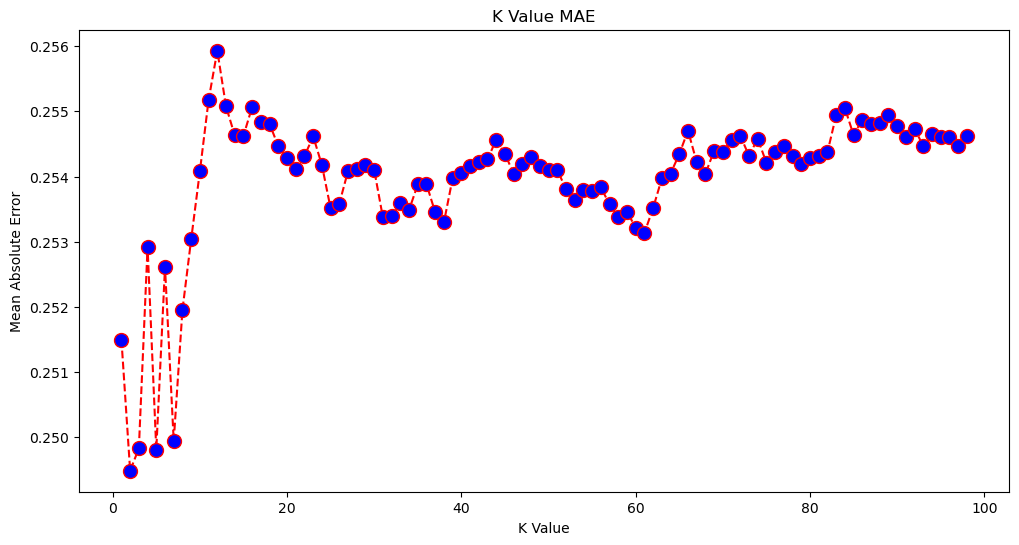

In [1092]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(12, 6))
plt.plot(range(1, 99), error, color='red', 
         linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
         
plt.title('K Value MAE')
plt.xlabel('K Value')
plt.ylabel('Mean Absolute Error')

**Obversations and Recommendations :**
1. More than 50% (\~32900) of the drivers have provided a Background check consent. Off them only 18% (~6100) have completed their first ride. This implies that there could be delays in background check, vehicle registration process which is delaying the process overall. This can be further explored.
<br><br>
2. I noticed that vehicle information is completely missing in the dataset.<br> 
    - 75% (\~41500) of the drivers have not provided any vehicle details.<br> 
    - There are 65 rows where driver has completed a first ride but not vehicle or vehicle information is added. Having accurate information about vehicles would have helped in providing much deeper analysis.<br> 
    <br>_Possible Reasons:_
    - There could have been a technical glitch in the App becuase of which data collection would not have happened
    - New Drivers could have problems in purchasing/leasing a new car which can be eased by providing good financing options.
<br><br>
3. More than 60% of the drivers gave a background check consent in the first 10 days of signing up.~10% of driver gave a background check consent more than 30 days later. Additional investigation into this can help a large number of drivers complete their sign up process and make their first drive.
<br><br>
4. Drivers who sign up through referral have completed their first rides more than other Sign Up channels. Lucrative referral programs for current drivers can help boost the Sign Up rate for new drivers.
